In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [48]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import keras_tuner as kt


In [49]:
data_dir = "../input/sports-classification"  

img_size = (128, 128) #resize images 
batch_size = 32


In [50]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir+"/train",
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir+"/valid",
    image_size=img_size,
    batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir+"/test",
    image_size=img_size,
    batch_size=batch_size
)

Found 13492 files belonging to 100 classes.
Found 500 files belonging to 100 classes.
Found 500 files belonging to 100 classes.


In [51]:
#Checking number of classes
class_names = train_ds.class_names
print("Number of classes:", len(class_names))
print("Example classes:", class_names[:10])


Number of classes: 100
Example classes: ['air hockey', 'ampute football', 'archery', 'arm wrestling', 'axe throwing', 'balance beam', 'barell racing', 'baseball', 'basketball', 'baton twirling']


In [52]:
#Optimize dataset performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


In [53]:
#Data Augmentation to avoid overfitting
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [54]:
#Build cnn
def build_model():
    model = models.Sequential([
        layers.Rescaling(1./255, input_shape=(128,128,3)),
        data_augmentation,

        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(len(class_names), activation='softmax')
    ])
    return model

In [55]:
model = build_model()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_10 (Sequential)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,507,812 (32.45 MB)

 Trainable params: 8,507,812 (32.45 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
#Train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/100
  1/422 ━━━━━━━━━━━━━━━━━━━━ 20:51 3s/step - accuracy: 0.0312 - loss: 4.6652

E0000 00:00:1756642644.556633      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_11_1/dropout_31_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


422/422 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - accuracy: 0.0162 - loss: 4.6138 - val_accuracy: 0.0560 - val_loss: 4.1701
Epoch 2/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.0550 - loss: 4.1084 - val_accuracy: 0.1340 - val_loss: 3.6193
Epoch 3/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.1077 - loss: 3.7227 - val_accuracy: 0.1740 - val_loss: 3.3787
Epoch 4/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.1375 - loss: 3.5515 - val_accuracy: 0.2180 - val_loss: 3.1385
Epoch 5/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.1700 - loss: 3.3877 - val_accuracy: 0.2220 - val_loss: 3.1512
Epoch 6/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.1915 - loss: 3.2660 - val_accuracy: 0.2760 - val_loss: 2.9686
Epoch 7/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.2172 - loss: 3.1409 - val_accuracy: 0.3280 - val_loss: 2.7886
Epoch 8/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.2325 - loss: 3.0646 - val_

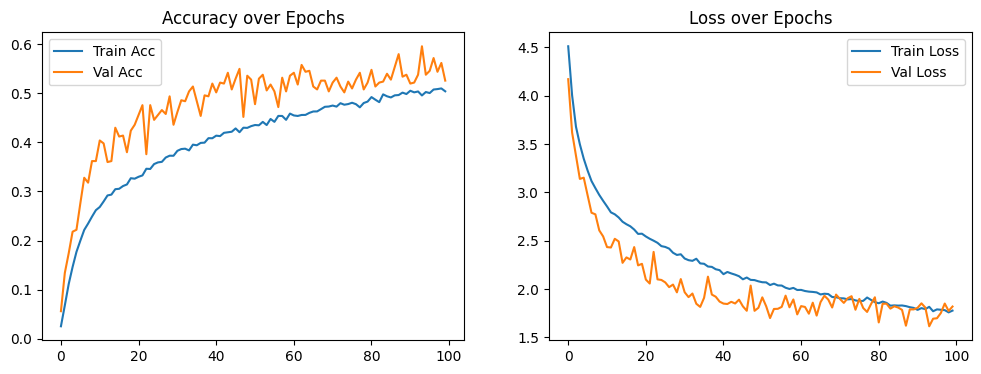

In [57]:
#Plot Accuracy & Loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy over Epochs')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()


In [58]:
#Evaluate on test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5876 - loss: 1.6190
Test Accuracy: 0.5680
Test Loss: 1.6782


In [59]:
#Get true labels and predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

#Classification report: Precision, Recall
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))





Classification Report:

                       precision    recall  f1-score   support

           air hockey       0.60      0.60      0.60         5
      ampute football       0.50      0.20      0.29         5
              archery       0.50      0.40      0.44         5
        arm wrestling       0.60      0.60      0.60         5
         axe throwing       0.50      0.20      0.29         5
         balance beam       0.71      1.00      0.83         5
        barell racing       0.60      0.60      0.60         5
             baseball       0.40      0.40      0.40         5
           basketball       0.29      0.40      0.33         5
       baton twirling       1.00      0.40      0.57         5
            bike polo       1.00      0.60      0.75         5
            billiards       1.00      1.00      1.00         5
                  bmx       0.20      0.40      0.27         5
              bobsled       0.00      0.00      0.00         5
              bowling       0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


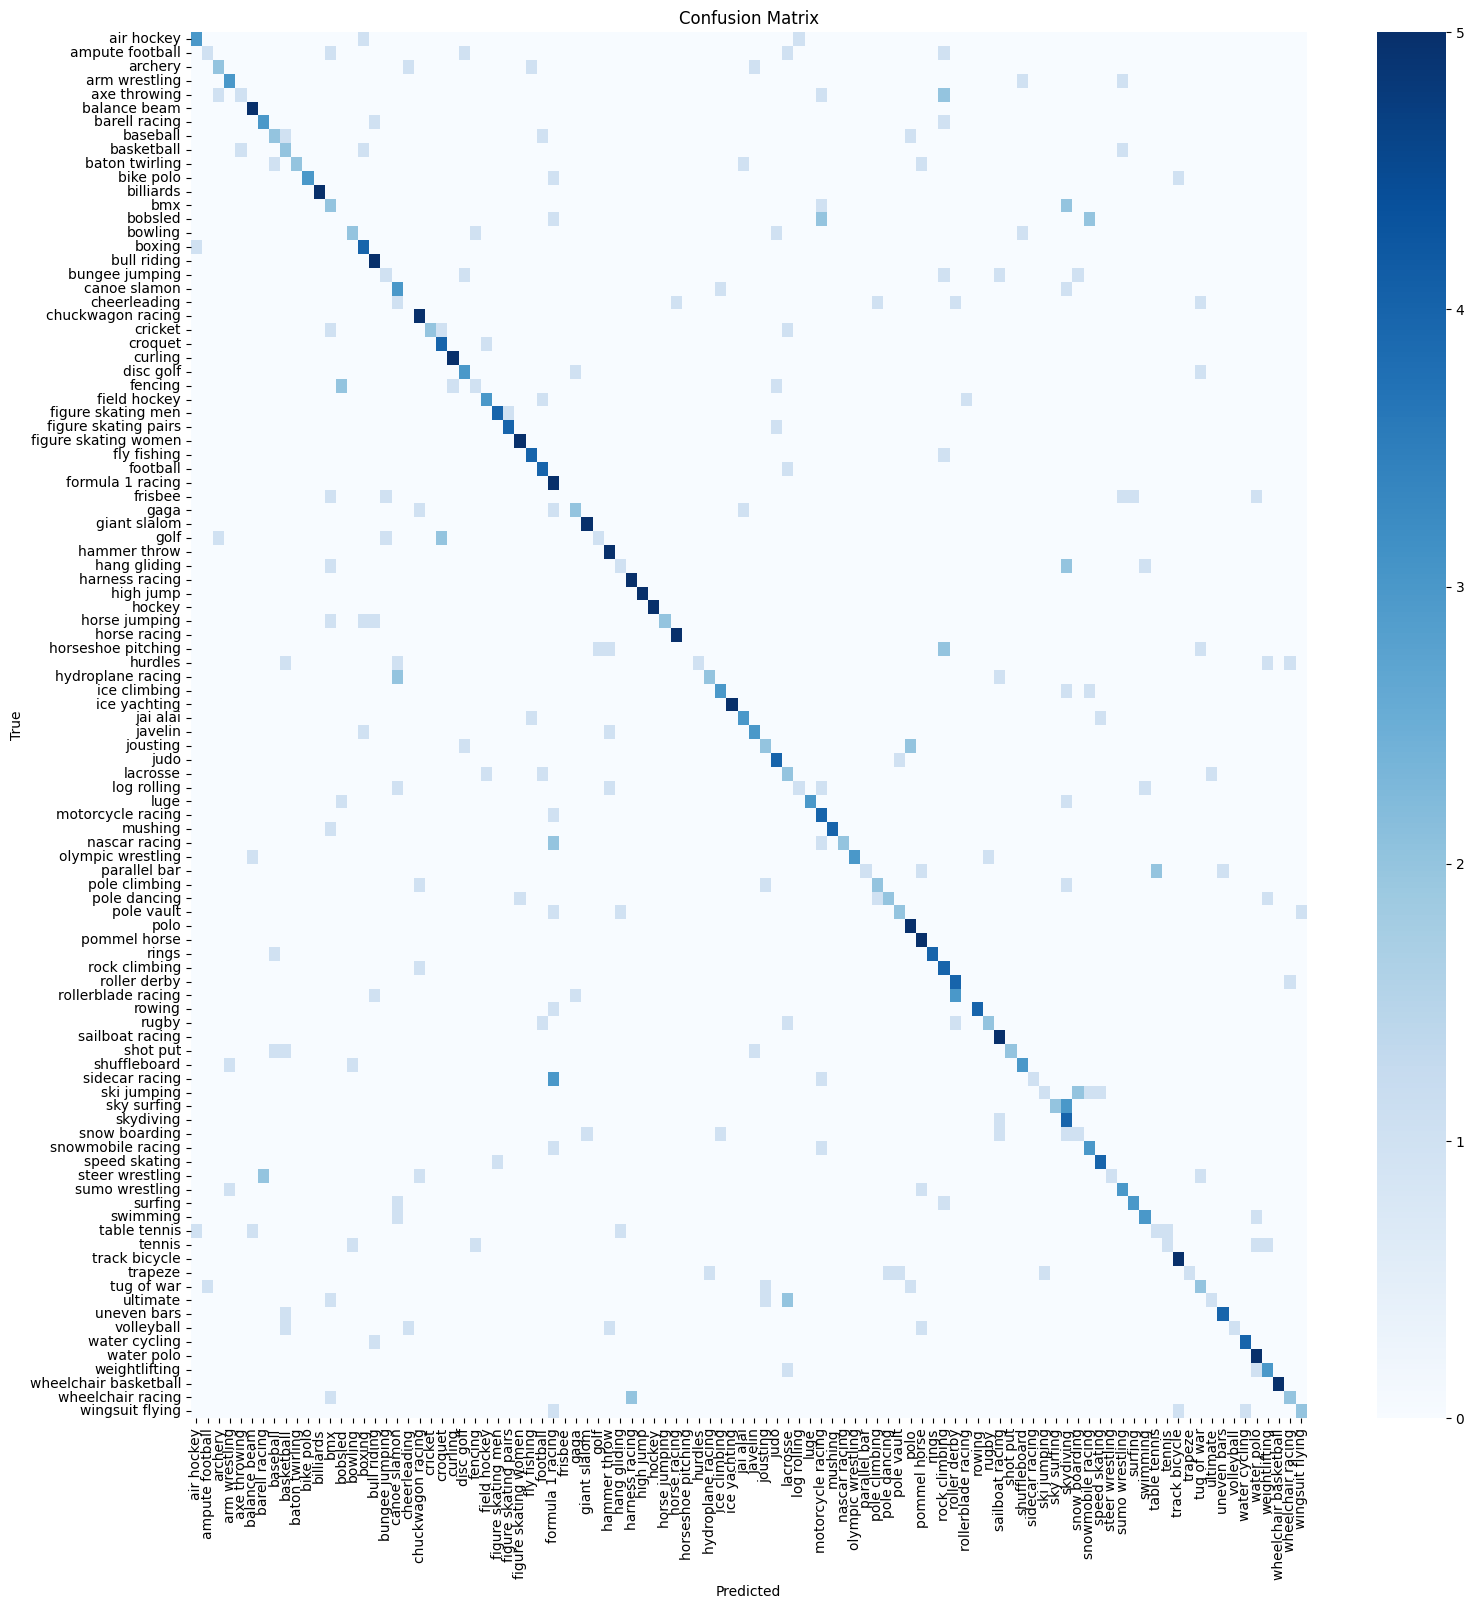

In [60]:
#Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(18, 18))
sns.heatmap(cm, annot=False, cmap="Blues", fmt="d",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [62]:
#hyper parameter tuning
def model(hp):
    model = models.Sequential([
        layers.Rescaling(1./255, input_shape=(128,128,3)),
        data_augmentation,

        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(2,2),
        layers.Dropout(hp.Float('dropout_rate', 0.3, 0.6, step=0.1)),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(2,2),
        layers.Dropout(hp.Float('dropout_rate2', 0.3, 0.6, step=0.1)),

        layers.Flatten(),
        layers.Dense(hp.Int('units', 128, 512, step=128), activation='relu'),
        layers.Dropout(hp.Float('dense_dropout', 0.3, 0.6, step=0.1)),
        layers.Dense(len(class_names), activation='softmax')
    ])

    hp_optimizer = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])
    if hp_optimizer == 'adam':
        opt = keras.optimizers.Adam(learning_rate=hp.Choice('lr', [0.001, 0.0005]))
    elif hp_optimizer == 'sgd':
        opt = keras.optimizers.SGD(learning_rate=hp.Choice('lr', [0.001, 0.0005]), momentum=0.9)
    else:
        opt = keras.optimizers.RMSprop(learning_rate=hp.Choice('lr', [0.001, 0.0005]))

    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
#Hyperband for fast search
tuner = kt.Hyperband(
    model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='tuner_results',
)

tuner.search(train_ds, validation_data=val_ds)

Trial 24 Complete [00h 02m 09s]
val_accuracy: 0.33799999952316284

Best val_accuracy So Far: 0.44200000166893005
Total elapsed time: 00h 29m 24s

Search: Running Trial #25

Value             |Best Value So Far |Hyperparameter
0.3               |0.4               |dropout_rate
0.5               |0.5               |dropout_rate2
512               |512               |units
0.3               |0.3               |dense_dropout
adam              |adam              |optimizer
0.001             |0.0005            |lr
20                |20                |tuner/epochs
7                 |7                 |tuner/initial_epoch
1                 |2                 |tuner/bracket
1                 |2                 |tuner/round
0023              |0014              |tuner/trial_id

Epoch 8/20
  1/422 ━━━━━━━━━━━━━━━━━━━━ 17:42 3s/step - accuracy: 0.2500 - loss: 2.8165

E0000 00:00:1756645746.584588      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


422/422 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - accuracy: 0.3118 - loss: 2.7045 - val_accuracy: 0.3760 - val_loss: 2.5831
Epoch 9/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.3387 - loss: 2.5750 - val_accuracy: 0.3740 - val_loss: 2.5082
Epoch 10/20
241/422 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.3399 - loss: 2.5403